In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
import torchvision.utils as vutils
from tqdm import tqdm, trange

$$y = x + 0.3 sin(2\pi(x + \epsilon)) + 0.3sin(4\pi(x + \epsilon)) + \epsilon$$
$$ \epsilon \sim N(0, 0.02)$$

In [169]:
N = 1000
x = np.linspace(0, 0.5, N)[:, np.newaxis]
x_test = np.linspace(-0.5, 1.0, 2 * N)[:, np.newaxis]
eps = np.random.normal(0, 0.02, x.shape)
y = x + 0.3 * np.sin(2 * np.pi * (x + eps))\
    + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test)\
    + 0.3 * np.sin(4 * np.pi * x_test)

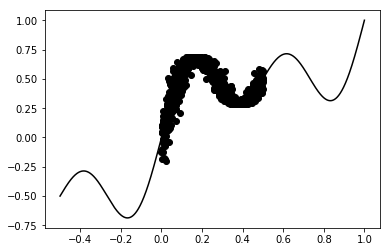

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y, color='k')
plt.plot(x_test, y_test, color='k')

In [171]:
x.shape

(1000, 1)

In [192]:
class Gaussian(object):
    def __init__(self, mu, rho):
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)
        
    def sample(self):
        epsilon = self.normal.sample(self.rho.size())
        return self.mu + self.sigma * epsilon
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def log_prob(self, input):
        return (-0.5 * math.log(2 * math.pi) - torch.log(self.sigma)\
            - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [193]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)
        
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1 - self.pi) * prob2)).sum()

In [194]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight paramters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight)\
                + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight)\
                + self.bias.log_prob(bias)
        else:
            self.log_prior = 0
            self.log_variational_posterior = 0
        return F.linear(input, weight, bias)

In [201]:
SAMPLES = 10
BATCH_SIZE = 32
OUTPUT_DIM = 1

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(1, 20)
        self.l2 = BayesianLinear(20, 20)
        self.l3 = BayesianLinear(10, 1)
        
    def forward(self, x, sample=False):
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = self.l3(x, sample)
        return x
    
    def log_prior(self):
        return self.l1.log_prior\
            + self.l2.log_prior\
            + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior\
            + self.l2.log_variational_posterior\
            + self.l3.log_variational_posterior
            
    def sample_elbo(self, input, target,
                    batch_size=BATCH_SIZE, 
                    output_dim=OUTPUT_DIM,
                    samples=SAMPLES):
        outputs = torch.zeros(samples, batch_size, output_dim)
        log_priors = torch.zeros(samples)
        log_variational_posteriors = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        mse_loss = F.mse_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior) / NUM_BATCHES\
            + mse_loss
        return loss, log_prior, log_variational_posterior, mse_loss
    
net = BayesianNetwork()

In [202]:
writer = SummaryWriter()

def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

def train(net, optimizer, epcoh):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        net.zero_grad()
        loss, log_prior, log_variational_posterior, mse_loss = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, mse_loss)
    write_weight_histograms(epoch+1)

In [203]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

  0%|          | 0/600 [00:00<?, ?it/s]


RuntimeError: size mismatch, m1: [2800 x 28], m2: [1 x 20] at /pytorch/aten/src/TH/generic/THTensorMath.c:2033

In [154]:
def test_ensemble(net):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES + 1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            outputs = torch.zeros(TEST_SAMPLES + 1, TEST_BATCH_SIZE, CLASSES)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1]
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))


In [156]:
test_ensemble(net)

Component 0 Accuracy: 8551/10000
Component 1 Accuracy: 8531/10000
Component 2 Accuracy: 8549/10000
Component 3 Accuracy: 8565/10000
Component 4 Accuracy: 8554/10000
Component 5 Accuracy: 8546/10000
Component 6 Accuracy: 8550/10000
Component 7 Accuracy: 8553/10000
Component 8 Accuracy: 8536/10000
Component 9 Accuracy: 8542/10000
Posterior Mean Accuracy: 8567/10000
Ensemble Accuracy: 8574/10000


In [151]:
x.max(0)

(tensor([[ 1.1146,  0.4821, -0.5735],
         [ 0.6798,  0.0434,  1.1977],
         [ 0.7786,  1.6315,  0.9597]]), tensor([[ 2,  1,  2],
         [ 2,  1,  1],
         [ 1,  0,  2]]))

In [152]:
help(x.max)

Help on built-in function max:

max(...) method of torch.Tensor instance
    max(dim=None, keepdim=False) -> Tensor or (Tensor, Tensor)
    
    See :func:`torch.max`



In [153]:
help(torch.max)

Help on built-in function max:

max(...)
    .. function:: max(input) -> Tensor
    
    Returns the maximum value of all elements in the :attr:`input` tensor.
    
    Args:
        input (Tensor): the input tensor
    
    Example::
    
        >>> a = torch.randn(1, 3)
        >>> a
        tensor([[ 0.6763,  0.7445, -2.2369]])
        >>> torch.max(a)
        tensor(0.7445)
    
    .. function:: max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
    
    Returns the maximum value of each row of the :attr:`input` tensor in the given
    dimension :attr:`dim`. The second return value is the index location of each
    maximum value found (argmax).
    
    If :attr:`keepdim` is ``True``, the output tensors are of the same size
    as :attr:`input` except in the dimension :attr:`dim` where they are of size 1.
    Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`), resulting
    in the output tensors having 1 fewer dimension than :attr:`input`.
    
    Args: